# day06: Gradient Descent for Linear Regression

# Objectives

* Learn how to fit weight parameters of Linear Regression to a simple dataset via gradient descent
* Understand impact of step size
* Understand impact of initialization


# Outline
* [Part 1: Loss and Gradient for 1-dim. Linear Regression](#part1)
* [Part 2: Gradient Descent Algorithm in a few lines of Python](#part2)
* [Part 3: Debugging with Trace Plots](#part3)
* [Part 4: Selecting the step size](#part4)
* [Part 5: Selecting the initialization](#part5)
* [Part 6: Using SciPy's built-in routines](#part6)

# Takeaways


* Gradient descent is a simple algorithm that can be implemented in a few lines of Python
* * Practical issues include selecting step size and initialization
* Step size matters a lot
* * Need to select carefully for each problem

* Initialization of the parameters can matter too!

* scipy offers some useful tools for gradient-based optimization
* * "L-BFGS-B" method is highly recommended if you have your loss and gradient functions available


In [ ]:
import numpy as np

In [ ]:
# import plotting libraries
import matplotlib
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8') # pretty matplotlib plots

import seaborn as sns
sns.set('notebook', font_scale=1.25, style='whitegrid')

# Create simple dataset:   y = 1.234 * x + noise

We will *intentionally* create a toy dataset where we know that a good solution has slope near 1.234.

Naturally, the best slope for the finite dataset of N=100 examples we create won't be exactly 1.234 (because of the noise added plus the fact that our dataset size is limited).

In [ ]:
def create_dataset(N=100, slope=1.234, noise_stddev=0.1, random_state=0):
    random_state = np.random.RandomState(int(random_state))

    # input features
    x_N = np.linspace(-2, 2, N)
    
    # output features
    y_N = slope * x_N + random_state.randn(N) * noise_stddev
    
    return x_N, y_N

In [ ]:
x_N, y_N = create_dataset(N=50, noise_stddev=0.3)

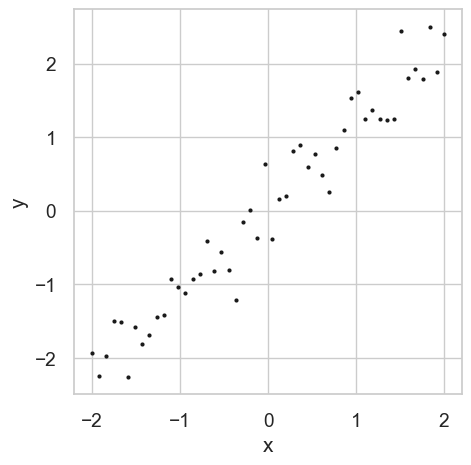

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
plt.plot(x_N, y_N, 'k.');
plt.xlabel('x');
plt.ylabel('y');

<a id="part1"></a>
# Part 1: Gradient Descent for 1-dim. Linear Regression

## Define model

Consider the *simplest* linear regression model. A single weight parameter $w \in \mathbb{R}$ representing the slope of the prediction line. No bias/intercept.

To make predictions, we just compute the weight multiplied by the input feature
$$
\hat{y}(x) = w \cdot x
$$

## Define loss function

We want to minimize the total *squared error* across all N observed data examples (input features $x_n$, output responses $y_n$)

\begin{align}
    \min_{w \in \mathbb{R}} ~~ &J(w)
    \\
    \text{calc_loss}(w) = J(w) &= \sum_{n=1}^N (y_n - w x_n)^2
\end{align}

### Exercise 1A: Complete the code below

You should make it match the math expression above.

In [ ]:
def calc_loss(w):
    ''' Compute loss for slope-only least-squares linear regression
    
    Args
    ----
    w : float
        Value of slope parameter

    Returns
    -------
    loss : float
        Sum of squared error loss at provided w value
    '''
    yhat_N = x_N * w
    sum_squared_error = 0.0 # todo compute the sum of squared error between y and yhat
    return sum_squared_error

# Define the gradient function

\begin{align}
\text{calc_grad}(w) = J'(w) &= \frac{\partial}{\partial w} [ \sum_{n=1}^N (y_n - w x_n)^2] 
\\
&= \sum_{n=1}^N 2 (y_n - w x_n) (-x_n)
\\
&= 2 \sum_{n=1}^N (w x_n - y_n) (x_n)
\\
&= 2  w \left( \sum_{n=1}^N x_n^2 \right) - 2 \sum_{n=1}^N y_n x_n
\end{align}

Below, we've implemented the gradient calculation in code for you.

You don't need to edit this, but look over it and verify you understand it.

In [ ]:
def calc_grad(w):
    ''' Compute gradient for slope-only least-squares linear regression
    
    Args
    ----
    w : float
        Value of slope parameter

    Returns
    -------
    g : float
        Value of derivative of loss function at provided w value
    '''
    g = 2.0 * w * np.sum(np.square(x_N)) - 2.0 * np.sum(x_N * y_N)
    return g

## Plot loss evaluated at each w from -3 to 8

We should see a "bowl" shape with one *global* minima, because our optimization problem is "convex"

In [ ]:
w_grid = np.linspace(-3, 8, 300) # create array of 300 values between -3 and 8

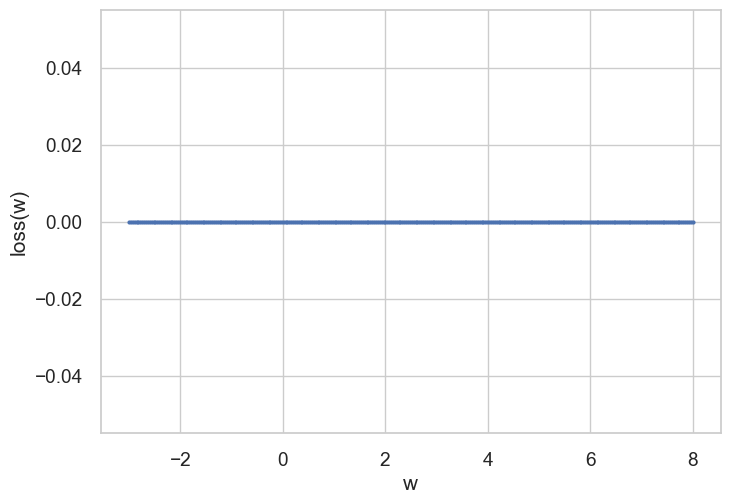

In [ ]:
loss_grid = np.asarray([calc_loss(w) for w in w_grid])
plt.plot(w_grid, loss_grid, 'b.-');
plt.xlabel('w');
plt.ylabel('loss(w)');

### Discussion 1b: Visually, at what value of $w$ does the loss function have a minima? Is it near where you would expect (hint: look above for the "true" slope value used to generate the data)

### Exercise 1c: Write NumPy code to identify which entry in the w_grid array corresponds to the lowest entry in the loss_grid array

Hint: use np.argmin

In [ ]:
# TODO write code here

## Sanity check: plot gradient evaluated at each w from -3 to 8

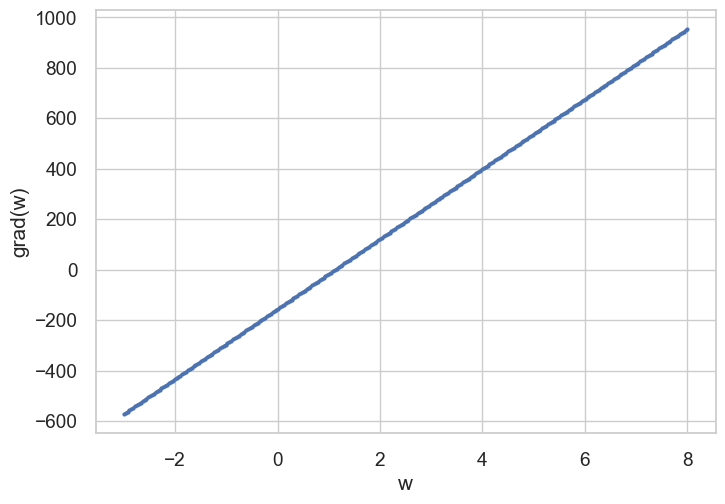

In [ ]:
grad_grid = np.asarray([calc_grad(w) for w in w_grid])
plt.plot(w_grid, grad_grid, 'b.-');
plt.xlabel('w');
plt.ylabel('grad(w)');

### Discussion 1d: Visually, at what value of $w$ does the gradient function cross zero? Is it the same place as the location of the minimum in the loss above?

TODO interpret the graph above and write your answer here, then discuss with your group

### Exercise 1d: Numerically, at which value of w does grad_grid cross zero?

We might try to estimate numerically where the gradient crosses zero.

We could do this in a few steps:

1) Compute the distance from each gradient in `grad_grid` to 0.0 (we could use just absolute distance)

2) Find the index of `grad_grid` with smallest distance (using `np.argmin`)

3) Plug that index into `w_grid` to get the $w$ value corresponding to that zero-crossing

In [ ]:
dist_from_zero_G = np.abs(grad_grid - 0.0)

zero_cross_index = 0 # TODO fix me for step 2 above

print("Zero crossing occurs at w = %.4f" % w_grid[0]) # TODO fix me for step 3 above

Zero crossing occurs at w = -3.0000


<a id="part2"></a>

## Part 2: Gradient Descent (GD) as an algorithm in Python


### Define minimize_via_grad_descent algorithm

Can you understand what each step of this algorithm does?

In [ ]:
def minimize_via_grad_descent(calc_loss, calc_grad, init_w=0.0, step_size=0.001, max_iters=100):
    ''' Perform minimization of provided loss function via gradient descent
    
    Args
    ----
    calc_loss : function
    calc_grad : function
    init_w : float
    step_size : float
    max_iters : positive int
    
    Return
    ----
    wopt: float
        array of optimized weights that approximately gives the least error
    info_dict : dict
        Contains information about the optimization procedure useful for debugging
        Entries include:
        * trace_loss_list : list of loss values
        * trace_grad_list : list of gradient values
    '''
    w = 1.0 * init_w 
    grad = calc_grad(w)

    # Create some lists to track progress over time (for debugging)
    trace_loss_list = []
    trace_w_list = []
    trace_grad_list = []

    for iter_id in range(max_iters):
        if iter_id > 0:
            w = w - step_size * grad
        
        loss = calc_loss(w)
        grad = calc_grad(w)    

        print("iter %4d/%d | w  % 8.4f | loss % 8.4f | grad % 8.4f" % (
            iter_id, max_iters, w, loss, grad))
    
        trace_loss_list.append(loss)
        trace_w_list.append(w)
        trace_grad_list.append(grad)
    
    wopt = w
    info_dict = dict(
        trace_loss_list=trace_loss_list,
        trace_w_list=trace_w_list, 
        trace_grad_list=trace_grad_list)
    
    return wopt, info_dict

### Discussion 2a: Which line of the above function does the *parameter update* happen?

Remember, in math, the parameter update of gradient descent is this:
$$
w \gets w - \alpha \nabla_w J(w)
$$

where $\alpha > 0$ is the step size.

In words, this math says *move* the parameter $w$ from its current value a *small step* in the "downhill" direction (indicated by gradient).

TODO write down here which line above *you* think it is, then discuss with your group

### Try it! Run GD with step_size = 0.001

Running the cell below will have the following effects:

1) one line will be printed for every iteration, indicating the current w value and its associated loss

2) the "optimal" value of w will be stored in the variable named `wopt` returned by this function

3) a dictionary of information useful for debugging will be stored in the `info_dict` returned by this function

In [ ]:
wopt, info_dict = minimize_via_grad_descent(calc_loss, calc_grad, step_size=0.001);

iter    0/100 | w    0.0000 | loss   0.0000 | grad -156.5566
iter    1/100 | w    0.1566 | loss   0.0000 | grad -134.8304
iter    2/100 | w    0.2914 | loss   0.0000 | grad -116.1192
iter    3/100 | w    0.4075 | loss   0.0000 | grad -100.0047
iter    4/100 | w    0.5075 | loss   0.0000 | grad -86.1265
iter    5/100 | w    0.5936 | loss   0.0000 | grad -74.1743
iter    6/100 | w    0.6678 | loss   0.0000 | grad -63.8807
iter    7/100 | w    0.7317 | loss   0.0000 | grad -55.0156
iter    8/100 | w    0.7867 | loss   0.0000 | grad -47.3808
iter    9/100 | w    0.8341 | loss   0.0000 | grad -40.8055
iter   10/100 | w    0.8749 | loss   0.0000 | grad -35.1427
iter   11/100 | w    0.9100 | loss   0.0000 | grad -30.2657
iter   12/100 | w    0.9403 | loss   0.0000 | grad -26.0656
iter   13/100 | w    0.9664 | loss   0.0000 | grad -22.4483
iter   14/100 | w    0.9888 | loss   0.0000 | grad -19.3331
iter   15/100 | w    1.0081 | loss   0.0000 | grad -16.6501
iter   16/100 | w    1.0248 | loss  

### Discussion 2b: Does it appear from the *loss* values in trace above that the GD procedure converged?

### Discussion 2c: Does it appear from the *parameter* values in trace above that the GD procedure converged?

### Exercise 2d: What exactly is the gradient of the returned "optimal" value of w?

Use your `calc_grad` function to check the result. What is the gradient of the returned `wopt`?

Does this look totally converged? Can you find a $w$ value that would be even better?

In [ ]:
# TODO call calc_grad on the return value from above

<a id="part3"></a>

## Part 3: Diagnostic plots for gradient descent

Let's look at some trace functions.

Whenever you run gradient descent, an *excellent* debugging strategy is the ability to plot the loss, the gradient magnitude, and the parameter of interest at every step of the algorithm.

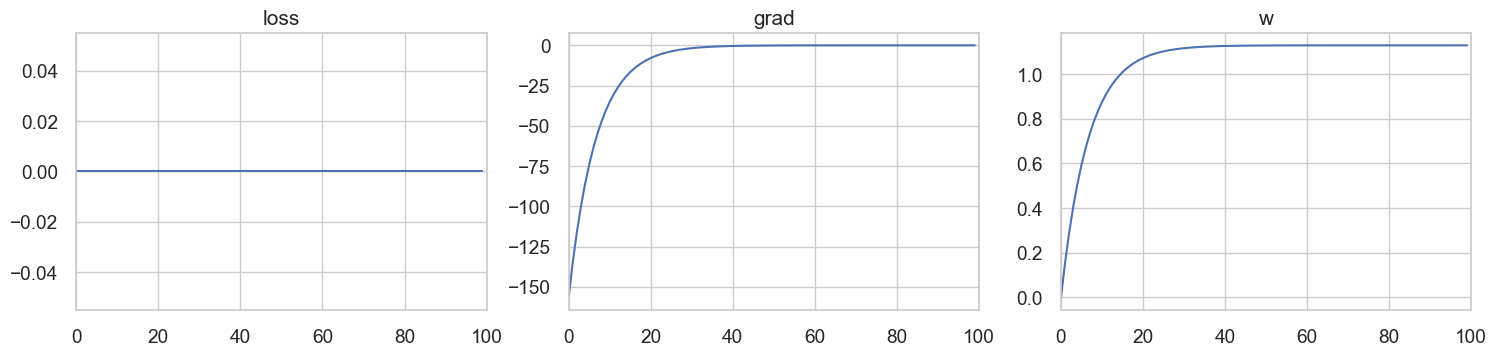

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=False, figsize=(18,3.6))

axes[0].plot(info_dict['trace_loss_list']);
axes[0].set_title('loss');
axes[1].plot(info_dict['trace_grad_list']);
axes[1].set_title('grad');
axes[2].plot(info_dict['trace_w_list']);
axes[2].set_title('w');

plt.xlim([0, 100]);

### Discussion 3a: What value do we expect the *loss* to converge to? Should it always be zero?

### Discussion 3b: What value do we expect the *gradient* to converge to? Should it always be zero?

<a id="part4"></a>


# Part 4: Larger step sizes

## Try with larger step_size = 0.014

In [ ]:
wopt, info_dict = minimize_via_grad_descent(calc_loss, calc_grad, step_size=0.014);

iter    0/100 | w    0.0000 | loss   0.0000 | grad -156.5566
iter    1/100 | w    2.1918 | loss   0.0000 | grad  147.6105
iter    2/100 | w    0.1252 | loss   0.0000 | grad -139.1756
iter    3/100 | w    2.0737 | loss   0.0000 | grad  131.2227
iter    4/100 | w    0.2366 | loss   0.0000 | grad -123.7243
iter    5/100 | w    1.9687 | loss   0.0000 | grad  116.6543
iter    6/100 | w    0.3356 | loss   0.0000 | grad -109.9884
iter    7/100 | w    1.8754 | loss   0.0000 | grad  103.7033
iter    8/100 | w    0.4236 | loss   0.0000 | grad -97.7774
iter    9/100 | w    1.7924 | loss   0.0000 | grad  92.1901
iter   10/100 | w    0.5018 | loss   0.0000 | grad -86.9221
iter   11/100 | w    1.7187 | loss   0.0000 | grad  81.9551
iter   12/100 | w    0.5713 | loss   0.0000 | grad -77.2720
iter   13/100 | w    1.6531 | loss   0.0000 | grad  72.8564
iter   14/100 | w    0.6331 | loss   0.0000 | grad -68.6932
iter   15/100 | w    1.5948 | loss   0.0000 | grad  64.7679
iter   16/100 | w    0.6881 | lo

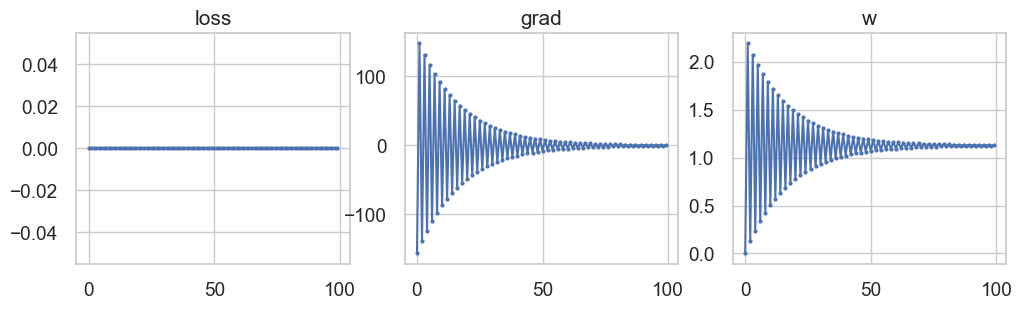

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=False, figsize=(12,3))

axes[0].plot(info_dict['trace_loss_list'], '.-');
axes[0].set_title('loss');
axes[1].plot(info_dict['trace_grad_list'], '.-');
axes[1].set_title('grad');
axes[2].plot(info_dict['trace_w_list'], '.-');
axes[2].set_title('w');

### Discussion 4a: What happens here? How is this step size different than in Part 3 above?

TODO discuss with your group

## Try with even larger step size 0.1

In [ ]:
wopt, info_dict = minimize_via_grad_descent(calc_loss, calc_grad, step_size=0.1, max_iters=25);

iter    0/25 | w    0.0000 | loss   0.0000 | grad -156.5566
iter    1/25 | w   15.6557 | loss   0.0000 | grad  2016.0654
iter    2/25 | w  -185.9509 | loss   0.0000 | grad -25961.9847
iter    3/25 | w   2410.2476 | loss   0.0000 | grad  334326.7829
iter    4/25 | w  -31022.4307 | loss   0.0000 | grad -4305310.2046
iter    5/25 | w   399508.5898 | loss   0.0000 | grad  55441851.8184
iter    6/25 | w  -5144676.5921 | loss   0.0000 | grad -713955275.4570
iter    7/25 | w   66250850.9536 | loss   0.0000 | grad  9193995485.9874
iter    8/25 | w  -853148697.6451 | loss   0.0000 | grad -118396145952.2056
iter    9/25 | w   10986465897.5754 | loss   0.0000 | grad  1524652410119.2183
iter   10/25 | w  -141478775114.3464 | loss   0.0000 | grad -19633789199698.5000
iter   11/25 | w   1821900144855.5037 | loss   0.0000 | grad  252835122143056.1250
iter   12/25 | w  -23461612069450.1094 | loss   0.0000 | grad -3255897185148334.0000
iter   13/25 | w   302128106445383.3125 | loss   0.0000 | grad  419

### Discussion 3b: What happens here with this even larger step size? Is it converging?

### Exercise 3c: What is the largest step size you can get to converge reasonably?

In [ ]:
# TODO try some other step sizes here
wopt, info_dict = minimize_via_grad_descent(calc_loss, calc_grad, step_size=0) # TODO fix step_size

iter    0/100 | w    0.0000 | loss   0.0000 | grad -156.5566
iter    1/100 | w    0.0000 | loss   0.0000 | grad -156.5566
iter    2/100 | w    0.0000 | loss   0.0000 | grad -156.5566
iter    3/100 | w    0.0000 | loss   0.0000 | grad -156.5566
iter    4/100 | w    0.0000 | loss   0.0000 | grad -156.5566
iter    5/100 | w    0.0000 | loss   0.0000 | grad -156.5566
iter    6/100 | w    0.0000 | loss   0.0000 | grad -156.5566
iter    7/100 | w    0.0000 | loss   0.0000 | grad -156.5566
iter    8/100 | w    0.0000 | loss   0.0000 | grad -156.5566
iter    9/100 | w    0.0000 | loss   0.0000 | grad -156.5566
iter   10/100 | w    0.0000 | loss   0.0000 | grad -156.5566
iter   11/100 | w    0.0000 | loss   0.0000 | grad -156.5566
iter   12/100 | w    0.0000 | loss   0.0000 | grad -156.5566
iter   13/100 | w    0.0000 | loss   0.0000 | grad -156.5566
iter   14/100 | w    0.0000 | loss   0.0000 | grad -156.5566
iter   15/100 | w    0.0000 | loss   0.0000 | grad -156.5566
iter   16/100 | w    0.0

<a id="part5"></a>


# Part 5: Sensitivity to initial conditions



### Exercise 5a: Try to call the defined procedure with a different initial condition for $w$. What happens?

You could try $w = 5.0$ or something else.

In [ ]:
# TODO try some other initial condition for init_w
wopt2, info_dict2 = minimize_via_grad_descent(calc_loss, calc_grad, init_w=0, step_size=0.001, max_iters=10) # TODO fix step_size

iter    0/10 | w    0.0000 | loss   0.0000 | grad -156.5566
iter    1/10 | w    0.1566 | loss   0.0000 | grad -134.8304
iter    2/10 | w    0.2914 | loss   0.0000 | grad -116.1192
iter    3/10 | w    0.4075 | loss   0.0000 | grad -100.0047
iter    4/10 | w    0.5075 | loss   0.0000 | grad -86.1265
iter    5/10 | w    0.5936 | loss   0.0000 | grad -74.1743
iter    6/10 | w    0.6678 | loss   0.0000 | grad -63.8807
iter    7/10 | w    0.7317 | loss   0.0000 | grad -55.0156
iter    8/10 | w    0.7867 | loss   0.0000 | grad -47.3808
iter    9/10 | w    0.8341 | loss   0.0000 | grad -40.8055


### Exercise 5b: Try again with another initial value. 

In [ ]:
# TODO try some other initial condition for init_w
wopt3, info_dict3 = minimize_via_grad_descent(calc_loss, calc_grad, init_w=0, step_size=0.001, max_iters=10) # TODO fix

iter    0/10 | w    0.0000 | loss   0.0000 | grad -156.5566
iter    1/10 | w    0.1566 | loss   0.0000 | grad -134.8304
iter    2/10 | w    0.2914 | loss   0.0000 | grad -116.1192
iter    3/10 | w    0.4075 | loss   0.0000 | grad -100.0047
iter    4/10 | w    0.5075 | loss   0.0000 | grad -86.1265
iter    5/10 | w    0.5936 | loss   0.0000 | grad -74.1743
iter    6/10 | w    0.6678 | loss   0.0000 | grad -63.8807
iter    7/10 | w    0.7317 | loss   0.0000 | grad -55.0156
iter    8/10 | w    0.7867 | loss   0.0000 | grad -47.3808
iter    9/10 | w    0.8341 | loss   0.0000 | grad -40.8055


### Exercise 5c: Make a trace plot

Make a trace plot showing convergence from multiple different starting values for $w$. What do you notice?

In [ ]:
# TODO

<a id="part6"></a>


# Part 6: Using scipy's built-in gradient optimization tools


In [ ]:
import scipy.optimize

Take a look at SciPy's built in minimization toolbox

<https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize>

We'll use "L-BFGS", a "quasi-newton" method, which you can get an intuition for here:

https://en.wikipedia.org/wiki/Newton%27s_method_in_optimization

In [ ]:
result = scipy.optimize.minimize(calc_loss, 0.0, jac=calc_grad, method='L-BFGS-B')

# Returns an object with several fields, let's print the result to get an idea
print(result)

  message: ABNORMAL_TERMINATION_IN_LNSRCH
  success: False
   status: 2
      fun: 0.0
        x: [ 0.000e+00]
      nit: 0
      jac: [-1.566e+02]
     nfev: 21
     njev: 21
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>


In [ ]:
print(str(result.message))

ABNORMAL_TERMINATION_IN_LNSRCH


In [ ]:
best_w = result.x
print(best_w)

[0.]
